In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

np.random.seed(0)

In [2]:
# 导入小车上山环境

env = gym.make('MountainCar-v0')
env.seed(0)
env = env.unwrapped

print('观测空间 = {}'.format(env.observation_space))
print('动作空间 = {}'.format(env.action_space))
print('位置范围 = {}'.format((env.min_position, env.max_position)))
print('速度范围 = {}'.format((-env.max_speed, env.max_speed)))
print('目标位置 = {}'.format(env.goal_position))

观测空间 = Box(2,)
动作空间 = Discrete(3)
位置范围 = (-1.2, 0.6)
速度范围 = (-0.07, 0.07)
目标位置 = 0.5


d:\programdata\miniconda3\envs\rl\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


失败退出


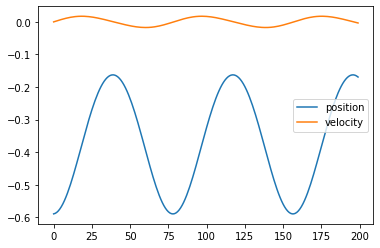

In [3]:
# 总是向右施力的智能体

positions, velocities = [], []
observation = env.reset()

# while True:
for _ in range(200):
    positions.append(observation[0])
    velocities.append(observation[1])
    next_observation, reward, done, _ = env.step(2)
    if done:
        break
    observation = next_observation

if next_observation[0] > 0.5:
    print('成功到达')
else:
    print('失败退出')

plt.figure()
plt.plot(positions, label='position')
plt.plot(velocities, label='velocity')
plt.legend()
plt.show()

In [4]:
# 砖瓦编码的实现

class TileCoder(object):
    
    def __init__(self, layers, features):
        self.layers = layers
        self.features = features
        self.codebook = {}
        return

    def get_feature(self, codeword):
        if codeword in self.codebook:
            return self.codebook[codeword]

        count = len(self.codebook)
        if count >= self.features:
            return hash(codeword) % self.features
        else:
            self.codebook[codeword] = count
            return count
    
    def __call__(self, floats=(), ints=()):
        dim = len(floats)
        scaled_floats = tuple(f * self.layers * self.layers for f in floats)
        features = []
        for layer in range(self.layers):
            codeword = (layer,) + tuple(int((f + (1 + dim * i) * layer) / self.layers) for i, f in enumerate(scaled_floats)) + ints
            feature = self.get_feature(codeword)
            features.append(feature)
        return features

In [5]:
# SARSA智能体与环境交互一回合

def play_sarsa(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation)
    
    while True:
        if render:
            env.render()
        
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        next_action = agent.decide(next_observation)
        
        if train:
            agent.learn(observation, action, reward, next_observation, done, next_action)
        
        if done:
            break
        
        observation, action = next_observation, next_action

    return episode_reward

In [6]:
# 期望SARSA智能体或Q学习智能体与环境的交互

def play_qlearning(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    
    while True:
        if render:
            env.render()
        
        action = agent.decide(observation)
        next_observation, reward, done, _ = env.step(action)
        episode_reward += reward
        
        if train:
            agent.learn(observation, action, reward, next_observation, done)
        
        if done:
            break
        
        observation = next_observation
    
    return episode_reward

In [7]:
# 函数近似SARSA算法智能体

class SARSAAgent(object):
    
    def __init__(self, env, layers=8, features=1893, gamma=1.0, learning_rate=0.03, epsilon=0.001):
        self.action_n = env.action_space.n
        self.obs_low = env.observation_space.low
        self.obs_scale = env.observation_space.high - env.observation_space.low
        self.encoder = TileCoder(layers, features)
        self.w = np.zeros(features)
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        return
    
    def encode(self, observation, action):
        states = tuple((observation - self.obs_low) / self.obs_scale)
        actions = (action,)
        return self.encoder(states, actions)
    
    def get_q(self, observation, action):
        features = self.encode(observation, action)
        return self.w[features].sum()
    
    def decide(self, observation):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_n)
        else:
            qs = [self.get_q(observation, action) for action in range(self.action_n)]
            return np.argmax(qs)
    
    def learn(self, observation, action, reward, next_observation, done, next_action):
        u = reward + (1.0 - done) * self.gamma * self.get_q(next_observation, next_action)
        td_error = u - self.get_q(observation, action)
        features = self.encode(observation, action)
        self.w[features] += self.learning_rate * td_error
        return

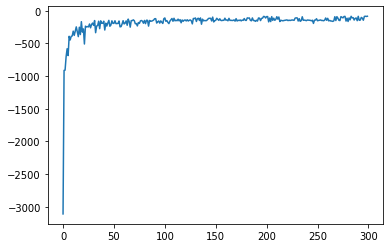

In [8]:
# 训练SARSA算法

agent = SARSAAgent(env)

episodes = 300
episode_rewards = []
for episode in tqdm(range(episodes)):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

In [9]:
# 测试SARSA算法

agent.epsilon = 0.0
episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} '.format(np.mean(episode_rewards)))

平均回合奖励 = -122.91 


In [10]:
# SARSA(lambda)算法智能体类

class SARSALambdaAgent(SARSAAgent):
    
    def __init__(self, env, layers=8, features=1893, gamma=1.0, learning_rate=0.03, epsilon=0.001, lambd=0.9):
        super(SARSALambdaAgent, self).__init__(env, layers, features, gamma, learning_rate, epsilon)
        self.lambd = lambd
        self.z = np.zeros(features)
        return
    
    def learn(self, observation, action, reward, next_observation, done, next_action):
        u = reward
        if not done:
            u += self.gamma * self.get_q(next_observation, next_action)
            self.z *= self.gamma * self.lambd
            features = self.encode(observation, action)
            self.z[features] = 1.0
        td_error = u - self.get_q(observation, action)
        self.w += self.learning_rate * td_error * self.z
        if done:
            self.z = np.zeros_like(self.z)
        return

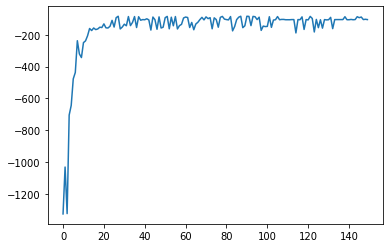

In [11]:
# 训练SARSA(lambda)

agent = SARSALambdaAgent(env)
episodes = 150
episode_rewards = []
for _ in tqdm(range(episodes)):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
plt.plot(episode_rewards)

In [12]:
# 测试SARSA(lambda)算法

agent.epsilon = 0.0
episode_rewards = [play_sarsa(env, agent) for _ in range(100)]
print('平均回合奖励 = {} '.format(np.mean(episode_rewards)))

平均回合奖励 = -100.67 
